In [24]:
# Importing the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import glob
import os

from astropy.io import fits

from scipy.optimize import least_squares
from scipy import ndimage

from uncertainties import *
from uncertainties.unumpy import *
from uncertainties.umath import *

from datetime import datetime

In [25]:
# Constants and values
xy_err = 0.5 # px
radec_err = 0.1 / 3600 # arcsec

pixel_size_m = 5.67e-6  # m

In [26]:
# Importing data
data = pd.read_csv('data/positions.csv')

data_unchanged = data.copy()

In [27]:
# Loading images
image_path = glob.glob(f"data/*.fits")

images = [fits.getdata(image_path) for image_path in image_path]

# Find the center of the image
x_center, y_center = (images[0].shape[1] // 2, images[0].shape[0] // 2)
print("Center of the image:", x_center, y_center)

# Convert coordinate system to have (0,0) at (x_center, y_center)
data['X'] = data['X'] - x_center
data['Y'] = data['Y'] - y_center 

Center of the image: 3132 2090


In [28]:
data

,ra,dec,X,Y
0,15:50:17.547,+02:11:47.43,-905.64,784.23
1,15:50:48.965,+04:28:39.83,-283.81,1159.22
2,15:44:16.074,+06:25:32.27,428.21,1349.10
3,15:45:23.479,+05:26:50.35,200.37,1211.44


In [29]:
# Convert RA and Dec to decimal degrees
def ra_to_decimal(ra):
    h, m, s = map(float, ra.split(':'))

    return (h + m / 60 + s / 3600) * 15 

def dec_to_decimal(dec):
    d, m, s = map(float, dec.split(':'))
    
    return d + (m / 60) + (s / 3600) if d >= 0 else d - (m / 60) - (s / 3600)

# Convert decimal degrees to RA and Dec
def decimal_to_ra_hms(ra_decimal):
    total_seconds = ra_decimal / 15 * 3600  
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = total_seconds % 60

    return f"{hours:02}:{minutes:02}:{seconds:.3f}"

def decimal_to_dec_dms(dec_decimal):
    is_negative = dec_decimal < 0
    dec_decimal = abs(dec_decimal)
    degrees = int(dec_decimal)
    total_minutes = (dec_decimal - degrees) * 60
    minutes = int(total_minutes)
    seconds = (total_minutes - minutes) * 60
    sign = '-' if is_negative else '+'

    return f"{sign}{degrees:02}:{minutes:02}:{seconds:.2f}"

# Affine transformation 
def compute_transformation_params(data):
    RA = data['ra'].values
    Dec = data['dec'].values
    X = data['X'].values
    Y = data['Y'].values
    
    # Residuals for least squares
    def residuals(params):
        a, b, c, d = params
        X_transformed = a * X + b * Y + c
        Y_transformed = b * X - a * Y + d

        return np.concatenate([
            X_transformed - RA, 
            Y_transformed - Dec
        ])

    # Initial guess for [a, b, c, d]
    initial_params = [0, 0, 0, 0]
    result = least_squares(residuals, initial_params)

    params = result.x
    J = result.jac
    res = result.fun
    res_x = res[:len(X)]
    res_y = res[len(X):]
    res_var = np.mean(res**2)

    covariance_matrix = res_var * np.linalg.inv(J.T @ J)

    param_err = np.sqrt(np.diag(covariance_matrix))

    params_comb = [ufloat(params[i], param_err[i]) for i in range(4)]

    print(f"Transformation Parameters: "
          f"\n a = {params_comb[0]},"
          f"\n b = {params_comb[1]},"
          f"\n c = {params_comb[2]},"
          f"\n d = {params_comb[3]}")

    return params_comb , res_x, res_y
# Rotation angle
def calculate_rotation_angle(a, b):
    theta = arctan2(b, a)  
    theta_deg = 180 * theta / np.pi
    
    print(f"Rotation Angle: {theta_deg} degrees")

    return theta_deg  

# X, Y to RA, Dec
def transform_coordinates(X, Y, params):
    a, b, c, d = params

    X = ufloat(X, xy_err)
    Y = ufloat(Y, xy_err)

    RA = a * X + b * Y + c
    Dec = b * X - a * Y + d

    RA_hms = decimal_to_ra_hms(RA.nominal_value)
    RA_hms_err = decimal_to_ra_hms(RA.std_dev)
    Dec_dms = decimal_to_dec_dms(Dec.nominal_value)
    Dec_dms_err = decimal_to_dec_dms(Dec.std_dev)

    print(f"RA = {RA_hms} ± {RA_hms_err}")
    print(f"Dec = {Dec_dms} ± {Dec_dms_err}")
    
    return RA, Dec

# Calculate focal length of the telescope
def calculate_focal_length(pixel_size_m, resolution):
    focal_length = (pixel_size_m * 206265) / resolution

    print(f"Focal Length of the Telescope: {focal_length:.4f} meters")
    return focal_length

def calculate_year_difference(date1_str, date2_str):
    date_format = "%d.%m.%Y"
    date1 = datetime.strptime(date1_str, date_format)
    date2 = datetime.strptime(date2_str, date_format)
    
    difference_in_years = (date2 - date1).days / 365.25  # considering leap years

    print(f"Difference in years: {difference_in_years}")

    return difference_in_years

In [30]:
# Convert RA and Dec to decimal degrees
data['ra'] = data['ra'].apply(ra_to_decimal)
data['dec'] = data['dec'].apply(dec_to_decimal)

In [31]:
# Least squares fit
params_comb, res_x, res_y = compute_transformation_params(data)

Transformation Parameters: 
 a = -0.00212+/-0.00016,
 b = 0.00225+/-0.00016,
 c = 234.09+/-0.20,
 d = 2.56+/-0.20


In [32]:
# Rotation angle transformation
rotation_angle = calculate_rotation_angle(params_comb[0], params_comb[1])

Rotation Angle: 133.3+/-3.0 degrees


In [33]:
# Ra, Dec of the center
ra_center_comb, dec_center_comb = transform_coordinates(0, 0, params_comb)

RA = 15:36:21.892 ± 00:00:49.168
Dec = +02:33:49.41 ± +00:12:17.52


In [34]:
# Ra, Dec of Barnard's Star
x_barnard = 3819 - x_center
y_barnard = 973 - y_center

ra_barnard_comb, dec_barnard_comb = transform_coordinates(x_barnard, y_barnard, params_comb)

RA = 15:20:28.744 ± 00:01:10.905
Dec = +01:44:25.44 ± +00:17:43.57


In [35]:
# Calculate FOV
ra_min_comb, dec_min_comb = transform_coordinates(-x_center, -y_center, params_comb)
ra_max_comb, dec_max_comb = transform_coordinates(x_center, y_center, params_comb)

fov_ra = (ra_min_comb - ra_max_comb) * 3600
fov_dec = (dec_min_comb - dec_max_comb) * 3600

print(f"\nField of View: RA = {fov_ra}, Dec = {fov_dec}")

RA = 15:44:7.522 ± 00:02:34.712
Dec = -08:55:9.23 ± +00:38:40.68
RA = 15:28:36.262 ± 00:02:34.712
Dec = +14:02:48.06 ± +00:38:40.68

Field of View: RA = (1.4+/-0.4)e+04, Dec = (-8.3+/-0.4)e+04


In [36]:
# Calculate resolution
resolution = sqrt(params_comb[0]**2 + params_comb[1]**2) * 3600

print(f"Resolution: {resolution} arcsec/px") 

Resolution: 11.1+/-0.6 arcsec/px


In [37]:
# Calculate focal length
focal_length = calculate_focal_length(pixel_size_m, resolution)

Focal Length of the Telescope: 0.1050+/-0.0055 meters


In [38]:
# Calculate Ra Dec for all stars
ra_trans = []
dec_trans = []
ra_trans_err = []
dec_trans_err = []
for i, row in data.iterrows():
    ra, dec = transform_coordinates(row['X'], row['Y'], params_comb)
    ra_trans.append(ra.nominal_value)
    dec_trans.append(dec.nominal_value)
    ra_trans_err.append(ra.std_dev)
    dec_trans_err.append(dec.std_dev)


RA = 15:51:6.602 ± 00:01:7.792
Dec = +02:11:20.48 ± +00:16:56.88
RA = 15:49:12.569 ± 00:01:7.670
Dec = +04:23:2.71 ± +00:16:55.06
RA = 15:44:52.627 ± 00:01:13.880
Dec = +06:23:22.05 ± +00:18:28.20
RA = 15:45:34.267 ± 00:01:8.599
Dec = +05:35:4.64 ± +00:17:8.99


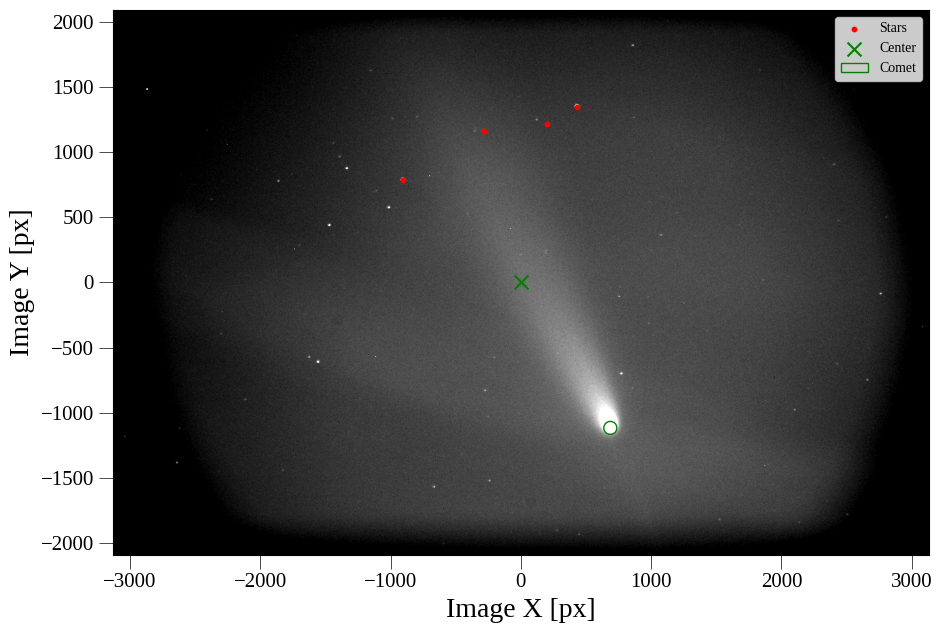

In [39]:
plt.rc("font", size=10)
plt.rcParams['font.family'] = 'Liberation Serif'

image = images[0]

vmin = 969
vmax = 2380

fig, ax = plt.subplots(figsize=(10, 6.5))

ax.set_xlabel('Image X [px]')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Image Y [px]')
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
plt.tight_layout()  

ax.imshow(image, cmap="gray", origin="lower", vmin=vmin, vmax=vmax, extent=[-x_center, x_center, -y_center, y_center])

ax.scatter(data['X'], data['Y'], c='r', s=10)
ax.scatter(0, 0, c='g', marker='x', s=100)

circle = plt.Circle((x_barnard, y_barnard), 50, color='g', fill=False)

plt.gca().add_patch(circle)

ax.legend(['Stars', 'Center', 'Comet'], loc='upper right', fontsize=10)

plt.savefig('images/barnard_sky.png')

plt.show()

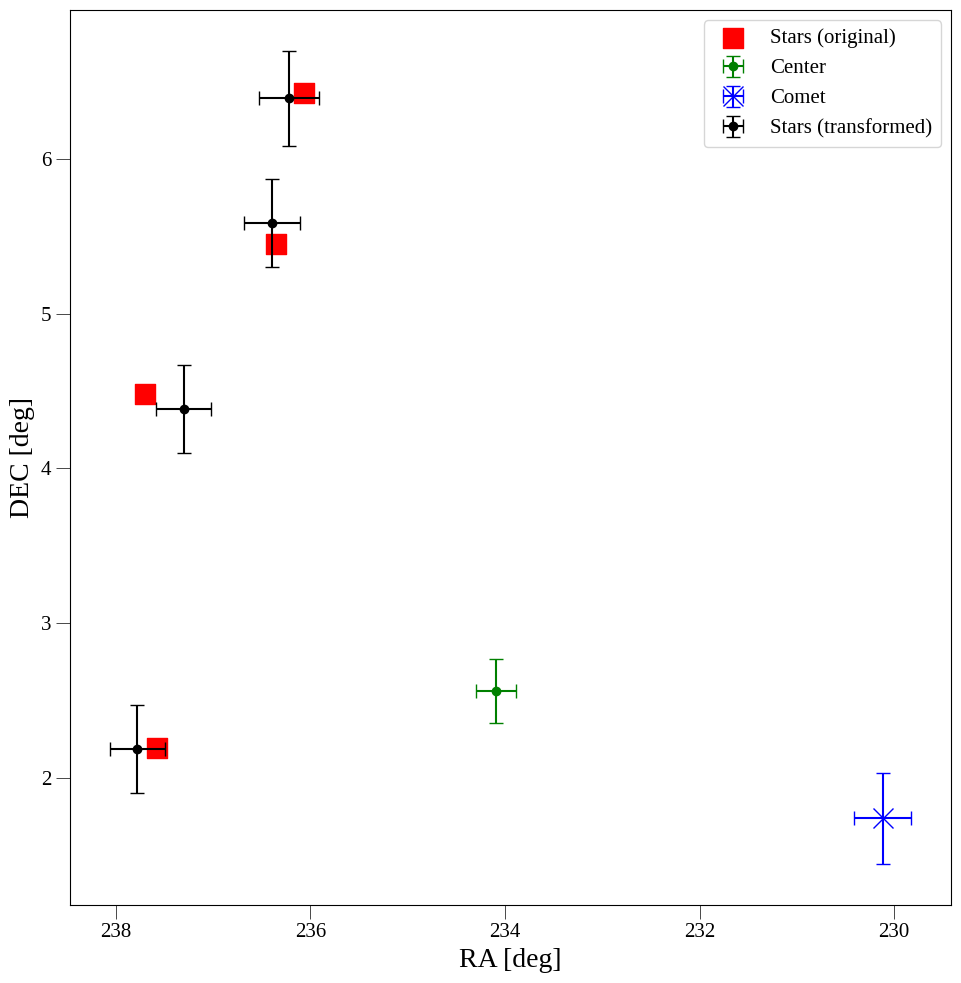

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlabel('RA [deg]')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('DEC [deg]')
ax.yaxis.label.set_fontsize(20)
ax.invert_xaxis()
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
plt.tight_layout()  

ax.scatter(data['ra'], data['dec'], c='r', s=200, marker='s', label='Stars (original)')

ax.errorbar(ra_center_comb.nominal_value, dec_center_comb.nominal_value, xerr=ra_center_comb.std_dev, yerr=dec_center_comb.std_dev, fmt='o', color='g', capsize=5, label='Center')

ax.errorbar(ra_barnard_comb.nominal_value, dec_barnard_comb.nominal_value, xerr=ra_barnard_comb.std_dev, yerr=dec_barnard_comb.std_dev, fmt='x', markersize=15, color='b', capsize=5, label='Comet')

ax.errorbar(ra_trans, dec_trans, xerr=ra_trans_err, yerr=dec_trans_err, fmt='o', color='black', capsize=5, label='Stars (transformed)')

ax.legend(loc='upper right', fontsize=15)

plt.savefig('images/barnard_radec.png')

plt.show()